# Imports

In [1]:
from XRDXRFutils import (Phase, DatabaseXRD, DataXRF, DataXRD, SpectraXRD, FastSpectraXRD, GaussNewton,
    PhaseList, ChiSearch, GammaMap, ChiMap, Phase, PhaseList, GammaSearch, GammaSearch_Secondary, GammaMap_Secondary, GammaMap_Partial)

from os.path import isdir
from os import makedirs, remove
from shutil import rmtree

import h5py
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit, least_squares

from numpy import (linspace, concatenate, sqrt, log, sin, cos, pi, deg2rad, histogram, array, unravel_index, savetxt,
    isnan, flip, sum, average, amax, nanmax, nanmin, nanmean, nanargmax, arange, empty, newaxis, stack, clip,
    quantile, ones, zeros, absolute)
import pandas as pd

from matplotlib.pyplot import (sca, show, fill_between, legend, imshow, subplots, plot, xlim, ylim,
    xlabel, ylabel, cm, title, scatter, colorbar, figure, vlines, savefig, get_cmap, hist)
from matplotlib import rcParams
from matplotlib.ticker import FuncFormatter, ScalarFormatter
from matplotlib.markers import MarkerStyle
from matplotlib.colors import BoundaryNorm
from matplotlib.lines import Line2D
from matplotlib.cm import get_cmap

from sklearn.cluster import KMeans, MiniBatchKMeans

from multiprocessing import Pool

from glob import glob
from PIL import Image

from pathlib import Path


def Dz_from_Da(a):
    z =  - a * sin(deg2rad(angle_incidence)) / sin(deg2rad(data.opt[2]))
    return z * channel_distance


def Dz_from_Ds(s):
    z = s * sin(deg2rad(angle_incidence)) / cos(deg2rad(data.opt[2]))
    return z * channel_distance


def f_linear(x, a, b):
    return a*x + b


def f_loss(x, t, y):
    return (x[0]*t + x[1]) - y


def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)


def read_raw_XRD(path_xrd, filename_scanning = 'Scanning_Parameters.txt', filename_calibration = 'calibration.ini', filename_h5 = 'xrd.h5'):
    return (DataXRD().read_params(path_xrd + filename_scanning).read(path_xrd)
            .calibrate_from_file(path_xrd + filename_calibration).remove_background().save_h5(path_xrd + filename_h5))


def correct_point(experimental_phases, idx_phase, gm, x, y):
    gn = gm.get_pixel(x, y)[idx_phase]
    phase = gn.make_phase()
    phase.set_name('created_%d'%idx_phase)
    phase.set_point(gm.get_index(x, y))
    experimental_phases[idx_phase] = phase

    
def rename_phase_in_database(database, name_old, name_new):
    for p in database[name_old]:
        p['_chemical_name_mineral'] = name_new
    database[name_new] = database[name_old]
    del database[name_old]


def find_element(element, labels, allow_loose = False):
    for j, label in enumerate(labels):
        if (element + '_') in label:   # search for the given string + '_' in XRF label
            return j
    if allow_loose:
        for j, label in enumerate(labels):
            if element in label:   # search for the given string in XRF label
                return j
    return None


def settings_lims(ax, x_min, x_max, y_min, y_max):
    if (x_min is not None):
        x_min -= 0.5
    if (x_max is not None):
        x_max += 0.5
    if (y_min is not None):
        y_min -= 0.5
    if (y_max is not None):
        y_max += 0.5
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)


def settings_plot(im, ax, x_min, x_max, y_min, y_max, position_colorbar, label_colorbar = None, powerlimits = None):
    settings_lims(ax, x_min, x_max, y_min, y_max)
    if (powerlimits is not None):
        formatter = ScalarFormatter(useMathText = True)
        formatter.set_scientific(True)
        formatter.set_powerlimits(powerlimits)
        cb = colorbar(im, ax = ax, cax = ax.inset_axes(position_colorbar), format = formatter)
        cb.ax.yaxis.set_offset_position('left')
    else:
        cb = colorbar(im, ax = ax, cax = ax.inset_axes(position_colorbar))
    if (label_colorbar is not None):
        cb.set_label(label_colorbar)


rcParams.update({
'image.origin': 'lower'
})

# Define paths and parameters

In [2]:
#path_shared = '/home/shared/'
path_shared = '../../shared/'

### Input ###
path_scan = path_shared + 'dataXRDXRF/MunchMuseum/M491/'
path_xrd = path_scan + 'ProfiloXRD/'          # XRD scan 
path_xrf = path_scan + 'ProfiloXRF/labels/'   # XRF scan
path_photo = path_scan + 'ProfiloFoto/'       # photo of the scanned section
path_zmap = path_shared + 'VenereBZPosition/'
path_database = path_shared + 'Database/'     # tabulated phases

### Output ###
subfolder_output = 'MunchMuseum/M491/Profilo/'
path_figures = 'figures/' + subfolder_output          # figures generated by the script
path_results = 'results/' + subfolder_output          # results generated by the script: raw data, tif maps
path_database_exp = 'databaseEXP/' + subfolder_output # experimental phases

### Parameters ###
min_theta = 20
max_theta = 53
min_intensity = 0.1  # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = 5 # selects the first n most intense peaks (if None, leaves all the peaks)
sigma = 0.2          # sigma used in the peaks of synthetic diffraction patterns

### Experimental setting ###
angle_incidence = 10.5 # angle between the incident beam and the plane of the painting
channel_distance = 50 # distance in microns between two adjacent channels of the detector

#### To reset results, delete output folders.
WARNING: every previous result will be lost. Use only if you want to delete all files in the data folders

In [3]:
do_you_want_to_delete = False

if do_you_want_to_delete:
    if isdir(path_figures):
        rmtree(path_figures)
    if isdir(path_results):
        rmtree(path_results)
    if isdir(path_database_exp):
        rmtree(path_database_exp)

#### Check if output folders exist. If not, create them.

In [4]:
if not isdir(path_figures):
    makedirs(path_figures)
if not isdir(path_results):
    makedirs(path_results)
if not isdir(path_database_exp):
    makedirs(path_database_exp)

# Show photo of scanned section

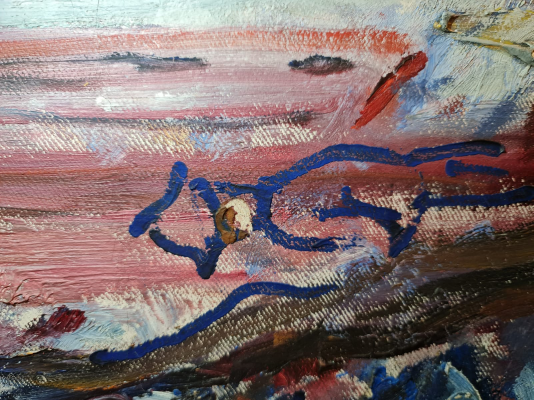

In [5]:
filenames = glob(path_photo + '*.jpg')
for filename in filenames:
    im = Image.open(filename)
    display(im.reduce(3))

# Read XRD Data and Database
To recalculate h5 file, change just for one time the filename that the cell tries to read (indicated by the comment)

In [6]:
%matplotlib inline
rcParams['font.size'] = 12

try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5') # to force the recalculation of h5 file, change this filename
    if any(not hasattr(data, attr) for attr in data.check_attributes):
        print('The present h5 file doesn\'t have all required information. Reading from raw data.')
        data = read_raw_XRD(path_xrd)
except:
    print('Reading from raw data.')
    data = read_raw_XRD(path_xrd)

y_x_ratio = data.shape[0] / data.shape[1]
print(f'Shape of data: {data.shape}')
print('Initial calibration:')
print(f'a = {data.opt[0]:.1f}, s = {data.opt[1]:.1f}, beta = {data.opt[2]:.3f}')
print(f'Theta range {list(data.fce_calibration([0, data.shape[2]], *data.opt))}')

database = DatabaseXRD().read_cifs(path_database)
print('\nPhases in database:', len(database))

Loading: ../../shared/dataXRDXRF/MunchMuseum/M491/ProfiloXRD/xrd.h5
Shape of data: (95, 170, 1280)
Initial calibration:
a = -1214.7, s = 1952.7, beta = 51.663
Theta range [19.77907407899562, 53.578190550653794]

Phases in database: 367


# Burnt pixels

### Show them
Choose a quantile on the value of maximum channel. All pixels above that quantile will be considered burnt pixel.

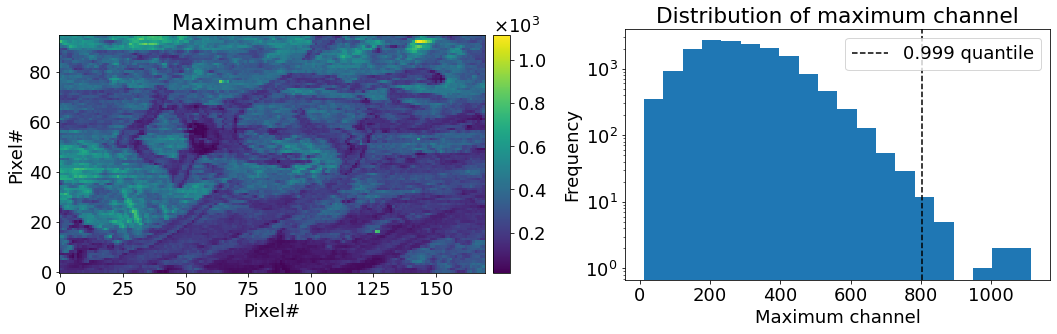

17 pixels out of 16150 are selected as burnt.


In [7]:
rcParams['font.size'] = 18

qtl = 0.999
#qtl = 1

data_max = (data.data - data.background).max(axis = 2)
indices_to_correct = data_max > quantile(data_max, qtl)

fig, axs = subplots(1, 2, figsize = (15, 8 * y_x_ratio))
fig.tight_layout(w_pad = 5)

ax = axs[0]
data_to_process = data.data - data.background
im = ax.imshow(data_max, interpolation = 'none')
formatter = ScalarFormatter(useMathText = True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 3))
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]), format = formatter)
cbar.ax.yaxis.set_offset_position('left')
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')
ax.set_title('Maximum channel')

ax = axs[1]
ax.hist(data_max.flatten(), bins = 'doane') # 'sqrt'
ax.axvline(quantile(data_max, qtl), c = 'black', ls = '--', label = f'{qtl} quantile')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('Maximum channel')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of maximum channel')

show()
print(f'{indices_to_correct.sum()} pixels out of {data.shape[0] * data.shape[1]} are selected as burnt.')

### Correct them
Substitute burnt pixel with the average of the non burnt ones.

In [8]:
data.data[indices_to_correct] = data.data[~indices_to_correct].mean(axis = 0, keepdims = True)
data.background[indices_to_correct] = data.background[~indices_to_correct].mean(axis = 0, keepdims = True)
data.intensity[indices_to_correct] = data.intensity[~indices_to_correct].mean(axis = 0, keepdims = True)
data.signal_background_ratio[indices_to_correct] = data.signal_background_ratio[~indices_to_correct].mean(axis = 0, keepdims = True)
data.rescaling[indices_to_correct] = data.rescaling[~indices_to_correct].mean(axis = 0, keepdims = True)

print(f'{indices_to_correct.sum()} pixels out of {data.shape[0] * data.shape[1]} were corrected.')

17 pixels out of 16150 were corrected.


# Aggregated information about XRD data

We process raw XRD data by subtracting the background (obtained by SNIP).
On this data we calculate aggregated information.

### Integral, average and maximum

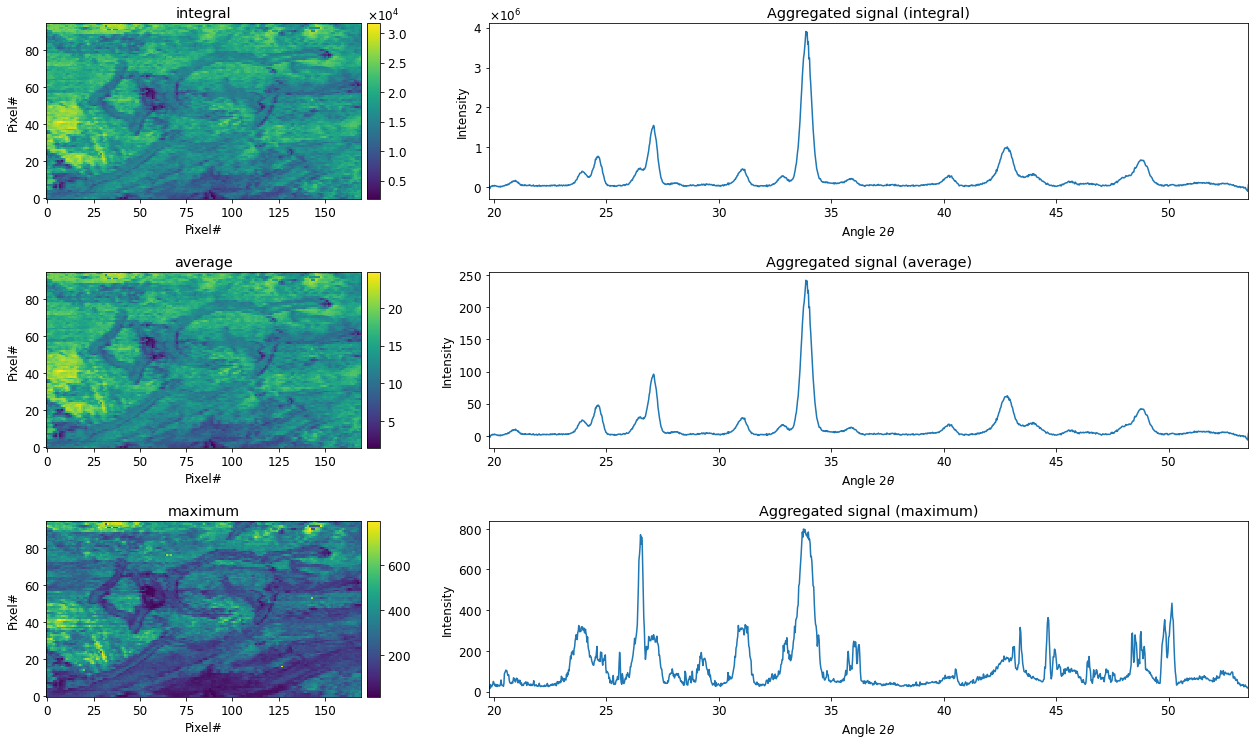

In [9]:
rcParams['font.size'] = 12

fig, axs = subplots(3, 2, figsize = (18, 3 * 6 * y_x_ratio), gridspec_kw = {'width_ratios': [1, 2]})
fig.tight_layout(h_pad = 4, w_pad = 5)

theta = data.fce_calibration(range(data.shape[-1]), *data.opt)
list_aggregations = ['integral', 'average', 'maximum']
list_functions = [sum, average, amax]
data_to_process = data.data - data.background

for i in range(len(list_aggregations)):
    
    image_aggregated = list_functions[i](data_to_process, axis = 2)
    ax = axs[i, 0]
    im = ax.imshow(image_aggregated, interpolation = 'none')
    formatter = ScalarFormatter(useMathText = True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 3))
    cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.02,0, 0.04, 1]), format = formatter)
    cb.ax.yaxis.set_offset_position('left')
    ax.set_title(list_aggregations[i])
    ax.set_ylabel(r'Pixel#')
    ax.set_xlabel(r'Pixel#')
    
    xrdpattern_aggregated = list_functions[i](data_to_process, axis = (0, 1))
    ax = axs[i, 1]
    ax.plot(theta, xrdpattern_aggregated)
    ax.ticklabel_format(useMathText = True)
    ax.set_xlim(theta[0], theta[-1])
    ax.set_xlabel(r'Angle $2\theta$')
    ax.set_ylabel('Intensity')
    ax.set_title(f'Aggregated signal ({list_aggregations[i]})')

savefig(f'{path_figures}aggregated_info.png', bbox_inches = 'tight', dpi = 300)
show()

### Rescaling and signal / background ratio

- 'Rescaling' shows, for each pixel, the maximum value of the experimental diffraction pattern after we subtract the background.
This value is used to obtain the rescaled signal in the interval [0, 1].
That's why we indicate this value as 'rescaling'.

- 'Signal/Noise' indicates the integral of the experimental diffraction pattern divided by the integral of the background.

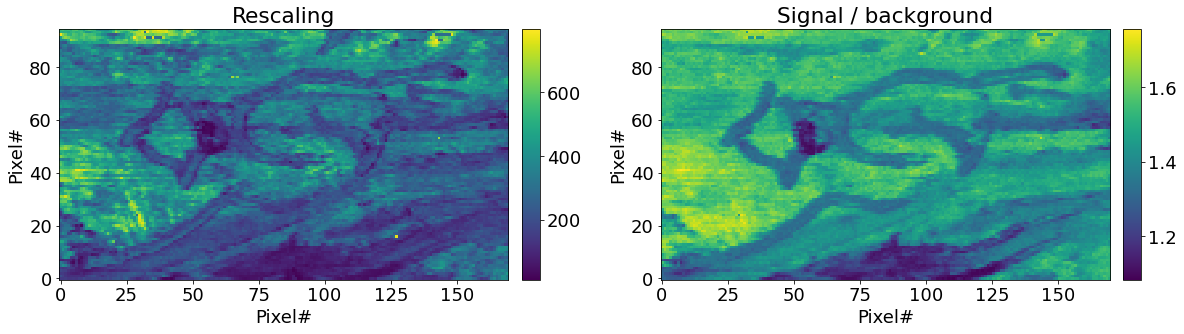

In [10]:
rcParams['font.size'] = 18

fig, axs = subplots(1, 2, figsize = (16, 8 * y_x_ratio))
fig.tight_layout(w_pad = 5)

ax = axs[0]
im = ax.imshow(data.rescaling.squeeze(), interpolation = 'none')
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
ax.set_title('Rescaling')
ax.set_ylabel(r'Pixel#')
ax.set_xlabel(r'Pixel#')

ax = axs[1]
im = ax.imshow(data.signal_background_ratio.squeeze(), interpolation = 'none')
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
ax.set_title('Signal / background')
ax.set_ylabel(r'Pixel#')
ax.set_xlabel(r'Pixel#')

show()

# Read XRF maps

If the orientation of tiff images does not correspond with XRD scans, flip them in this cell

In [11]:
data_xrf = DataXRF()
data_xrf.read_tiff(path_xrf)
data_xrf.labels = flip(data_xrf.labels, axis = [1]) # choose the axes to flip
print(f'Found {data_xrf.labels.shape[2]} images')

Found 24 images


### Correct burnt pixels in each XRF map
Choose a quantile on the value of XRF intensity. All pixels above that quantile will be corrected as burnt pixels and will be assigned the threshold value.

In [12]:
qtl = 0.999
#qtl = 1

qtl_calculated = quantile(data_xrf.labels, qtl, axis = (0, 1))[newaxis, newaxis, :]
n_corrected = (data_xrf.labels > qtl_calculated).sum() / data_xrf.labels.shape[-1]
data_xrf.labels = clip(data_xrf.labels, None, qtl_calculated)
print(f'{n_corrected:.0f} pixels out of {data_xrf.labels.shape[0] * data_xrf.labels.shape[1]} were corrected on average in each XRF map.')

17 pixels out of 16150 were corrected on average in each XRF map.


### Correct wrong scale that includes negative values

In [13]:
data_xrf.labels -= data_xrf.labels.min(axis = (0, 1), keepdims = True)

# Explore XRF data

### All XRF maps

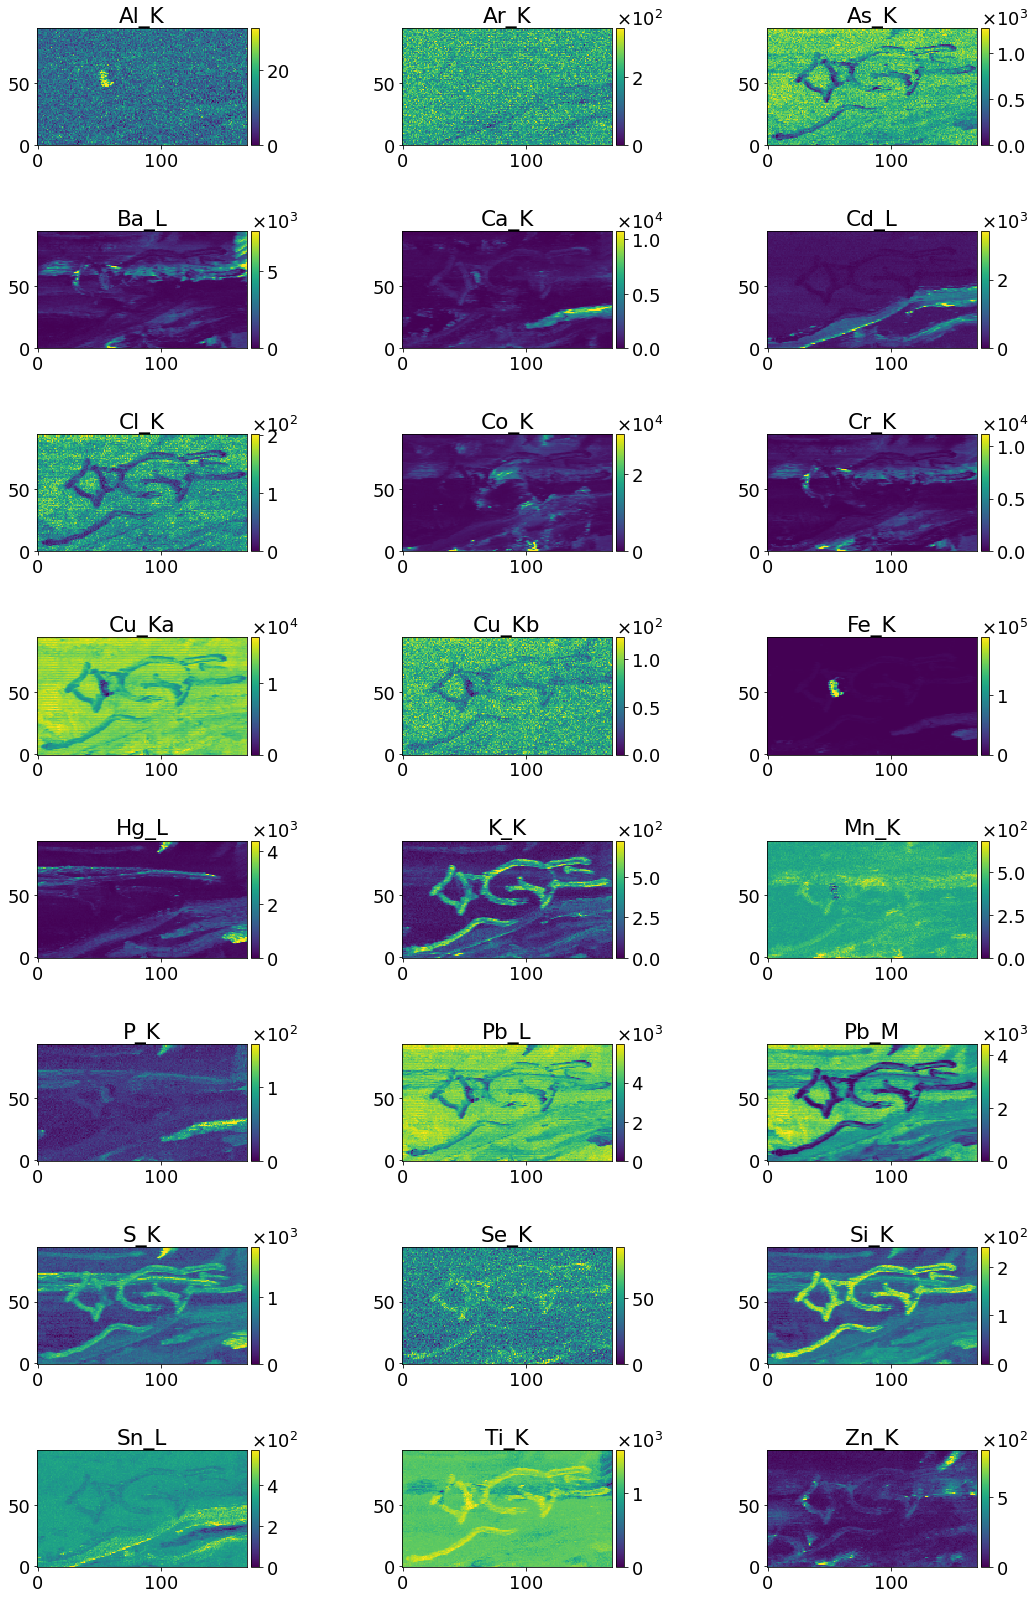

In [14]:
#%matplotlib qt
%matplotlib inline
n_of_columns = 3
rcParams['font.size'] = 18

n_of_pictures = len(data_xrf.metadata['labels'])
n_of_rows = n_of_pictures // n_of_columns
if (n_of_pictures % n_of_columns):
    n_of_rows += 1

fig, axs = subplots(n_of_rows, n_of_columns, figsize = (5 * n_of_columns, 5 * n_of_rows * y_x_ratio))
fig.tight_layout(h_pad = 3, w_pad = 3)
for i, label in enumerate(data_xrf.metadata['labels']):
    i_row = i // n_of_columns
    i_column = i % n_of_columns
    if n_of_rows == 1:
        ax = axs[i_column]
    else:
        ax = axs[i_row, i_column]
    im = ax.imshow(data_xrf.labels[..., i], interpolation = 'none')
    formatter = ScalarFormatter(useMathText = True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 2))
    cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]), format = formatter)
    cb.ax.yaxis.set_offset_position('left')
    ax.set_title(label)
show()

### XRF maps of selected element

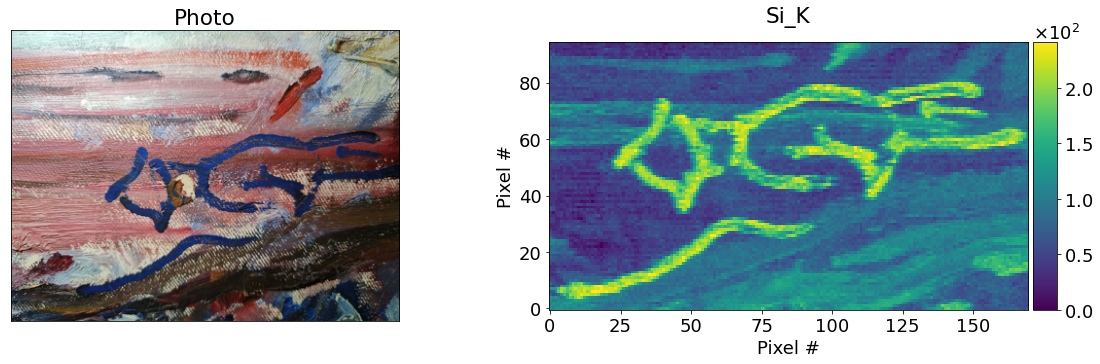

In [15]:
%matplotlib inline
#%matplotlib qt
rcParams['font.size'] = 18

element_chosen = 'Si'

for i, label in enumerate(data_xrf.metadata['labels']):
    #if element_chosen in label:   # search for the given string in XRF label
    if element_chosen + '_' in label:   # search for the given string + '_' in XRF label
        fig, axs = subplots(1, 2, figsize = (16, 9 * y_x_ratio))
        fig.tight_layout(w_pad = 3)

        ax = axs[0]
        filename_photo = glob(path_photo + '*.jpg')[0]
        im = Image.open(filename_photo).transpose(1)
        ax.imshow(im.reduce(4))
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_title('Photo')
        
        ax = axs[1]
        im = ax.imshow(data_xrf.labels[..., i], interpolation = 'none')
        formatter = ScalarFormatter(useMathText = True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-2, 2))
        cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.01, 0, 0.05, 1]), format = formatter)
        cb.ax.yaxis.set_offset_position('left')
        ax.set_xlabel('Pixel #')
        ax.set_ylabel('Pixel #')
        ax.set_title(label, y = 1.05)

show()

### RGB map from 3 XRF maps

Pb:	Pb_L
Hg:	Hg_L
Si:	Si_K


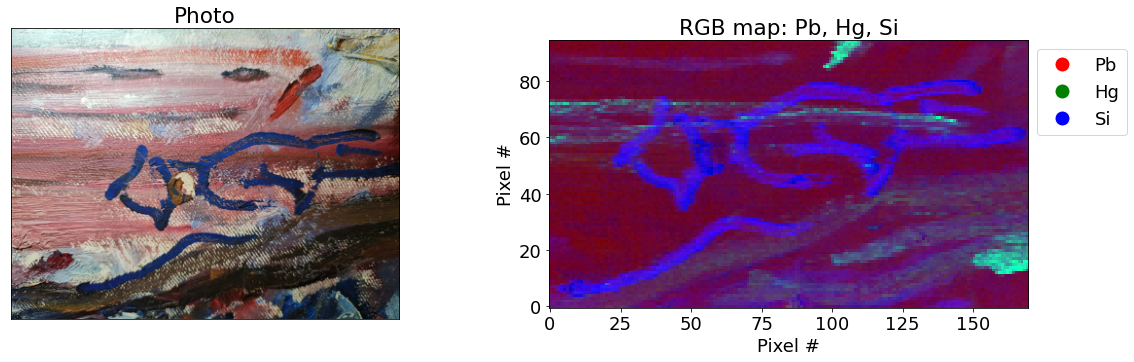

In [16]:
rcParams['font.size'] = 18
elements_chosen = ['Pb', 'Hg', 'Si']
factors_intensity = [0.5, 1, 1]

check_find = [False] * 3
image_rgb = empty(list(data_xrf.labels.shape[:2]) + [3])
for i, elem in enumerate(elements_chosen):
    j = find_element(elem, data_xrf.metadata['labels'])
    if j is None:
        print(elem + ' not found.')
    else:
        print(elem + ':\t' + data_xrf.metadata['labels'][j])
        check_find[i] = True
        image_rgb[..., i] = data_xrf.labels[..., j]

if all(check_find):
    image_rgb -= image_rgb.min(axis = (0, 1), keepdims = True)
    image_rgb /= image_rgb.max(axis = (0, 1), keepdims = True)
    image_rgb *= array(factors_intensity)[newaxis, newaxis, :]
    #image_rgb /= image_rgb.max()
    image_rgb = clip(image_rgb, 0, 1)

    fig, axs = subplots(1, 2, figsize = (16, 9 * y_x_ratio))
    fig.tight_layout(w_pad = 3)

    ax = axs[0]
    filename_photo = glob(path_photo + '*.jpg')[0]
    im = Image.open(filename_photo).transpose(1)
    ax.imshow(im.reduce(4))
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title('Photo')
        
    ax = axs[1]
    im = ax.imshow(image_rgb, interpolation = 'none')
    legend_elements = [
        Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = c, markersize = 15, label = elements_chosen[i])
            for i, c in enumerate(['r', 'g', 'b'])
    ]
    ax.legend(handles = legend_elements, bbox_to_anchor = (1, 1), loc = 'upper left')
    ax.set_xlabel('Pixel #')
    ax.set_ylabel('Pixel #')
    ax.set_title('RGB map: ' + ', '.join(elements_chosen))

    show()

extent = ax.get_tightbbox(fig.canvas.renderer).expanded(1.05, 1.05).transformed(fig.dpi_scale_trans.inverted())
fig.savefig(path_figures + 'RGB_' + '_'.join(elements_chosen) + '.png', bbox_inches = extent)

# List of phases

### Search phases with given elements

In [31]:
elements_chosen = ['Hg']
XRF_intensity_threshold = 0.7

i = find_element(elements_chosen[0], data_xrf.metadata['labels'])
print('Element chosen for the map of XRF intensity: ' + data_xrf.metadata['labels'][i])
print(f'Threshold: {XRF_intensity_threshold}')

indices_XRF_sel = zeros(data.shape[:2], bool)
map_XRF_intensity = data_xrf.labels[..., i] / data_xrf.labels[..., i].max()
for x in range(data.shape[1]):
    for y in range(data.shape[0]):
        if map_XRF_intensity[y, x] >= XRF_intensity_threshold:
            indices_XRF_sel[y, x] = True
print(f'Selected pixels: {indices_XRF_sel.sum()}')

list_name = []
list_formula = []
list_number = []
list_index_best_average = []
list_value_best_average = []
list_index_best_max = []
list_value_best_max = []
for k, v in sorted(database.items()):
    p = v[0]
    if '_chemical_formula_sum' in p:
        if all(e in p['_chemical_formula_sum'] for e in elements_chosen):
            list_name.append(k)
            list_formula.append(p['_chemical_formula_sum'])
            list_number.append(len(v))
            
            print(f'Calculations for {k} ({len(v)})...')
            phases_samples = [p for p in v]
            gm = GammaMap_Partial().from_data(data, phases_samples, indices_XRF_sel, sigma = sigma, min_theta = min_theta,
                                              max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)
            gm = gm.fit_cycle(gamma = True, steps = 5)
            overlap = gm.overlap3_area_ratio()
            overlap_average = overlap.mean(axis = 0)
            overlap_max = overlap.max(axis = 0)
            
            j = nanargmax(overlap_average)
            list_index_best_average.append(j)
            list_value_best_average.append(overlap_average[j])
            j = nanargmax(overlap_max)
            list_index_best_max.append(j)
            list_value_best_max.append(overlap_max[j])
            
            print('Done.')

phases_from_elements = pd.DataFrame(
    columns = ['Name in database', 'Chemical formula', 'Number of samples', 'Index best average', 'Value best average', 'Index best maximum', 'Value best maximum'],
    data = array([list_name, list_formula, list_number, list_index_best_average, list_value_best_average, list_index_best_max, list_value_best_max]).T
)#.iloc[0:3] # if there are too many lines, change this to select the lines to show

#phases_from_elements.style.format({
#    'Value best average': '{:.3f}',
#    'Value best maximum': '{:.3f}',
#})
phases_from_elements

Element chosen for the map of XRF intensity: Hg_L
Threshold: 0.7
Selected pixels: 119
Calculations for Cadmium mercurate (1)...
Using 8 CPUs
Using 8 CPUs
Done.
Calculations for Cd Hg (S C N)4 (2)...
Using 8 CPUs
Using 8 CPUs
Done.
Calculations for Cinnabar (3)...
Using 8 CPUs
Using 8 CPUs
Done.
Calculations for Metacinnabar (2)...
Using 8 CPUs
Using 8 CPUs
Done.


,Name in database,Chemical formula,Number of samples,Index best average,Value best average,Index best maximum,Value best maximum
0,Cadmium mercurate,Cd Hg O2,1,0,0.10108829633957002,0,0.21193618108676127
1,Cd Hg (S C N)4,Cd Hg S4,2,1,0.0539976338607099,1,0.09590384748651262
2,Cinnabar,Hg S,3,0,0.46285082739020356,1,0.6128889063899117
3,Metacinnabar,Hg S,2,1,0.23028921821638215,0,0.2883520755147641


In [30]:
phases_from_elements.iloc[0]['Value best average']

'0.06079935879004941'

In [18]:
overlap.shape

(55, 16)

In [19]:
overlap_average.shape

(16,)

In [20]:
gs = gm[0][0]

In [21]:
gs.overlap_area()

1.0866234160240624

In [22]:
gs.intensity.sum()

51.64271950204508

In [23]:
from numpy import maximum
maximum(gs.intensity, 0).sum()

57.52271565492635

In [24]:
gs.overlap_area_ratio()

0.01889033582041953

In [24]:
overlap

array([[ -4.50296743,  -4.74547165,  -4.63428544,  -4.56762412,
         -4.54498432,  -4.42799596,  -4.34516095,  -4.59899494,
         -5.00321542,  -4.57941107,  -4.30158097,  -5.17272891,
         -6.42322863,  -4.77643443,  -3.18142098, -15.26215163],
       [-10.64156335,  -9.95574935, -10.14413929, -10.51945847,
        -10.59152499, -10.57543584, -10.49451909, -11.69466107,
        -10.3670904 , -10.28909494, -11.62796359, -11.18747377,
         -9.88899038,  -9.83895628,  -6.32354617, -17.89889193],
       [ -7.20269737,  -6.44774767,  -6.71578541,  -7.03459719,
         -7.15707669,  -7.19550808,  -7.13520087,  -8.96839006,
         -7.52862756,  -6.88440273,  -8.43838053,  -8.10968083,
         -6.87710118,  -6.57360635,  -1.58945144, -25.13449485],
       [-11.38423204, -10.75554569, -10.65713533, -11.13118147,
        -11.31827035, -11.48565124, -11.72401871, -12.09806022,
        -10.26357312, -11.01273245, -12.40529022, -11.77069328,
        -11.41560857, -11.27196765,  

### Add these phases to a file

This cell writes the list of names of selected phases into the file `phases_selection.dat`.

If the file does not exist, the cell creates it.

In [21]:
file = open('phases_selection.dat', 'a')
for phase_name in list_name:
    file.write(phase_name + '\n')
file.close()

### Delete the list of phases (WARNING)

Delete the file `phases_selection.dat`, with the list of names of selected phases.

In [38]:
remove('phases_selection.dat')

# Check phases in a given point
- `phases_calibration`: the cell will calibrate the experimental XRD pattern on the mix of these phases
- `phase_compare`: the diffraction lines of this phase will be shown for comparison

For simplification, you can define phases. Otherwise, phases can be selected iteratively from database using 'Tab'.

In [22]:
hydrocerussite = database['Hydrocerussite'][0]
lazurite = database['Lazurite'][0]
cinnabar = database['Cinnabar'][1]

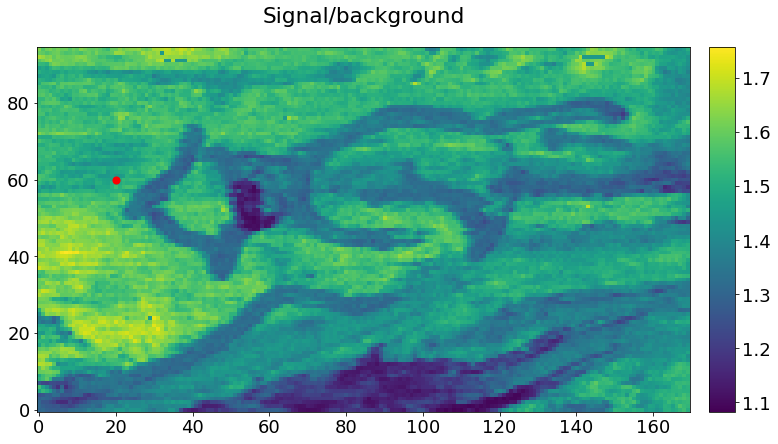

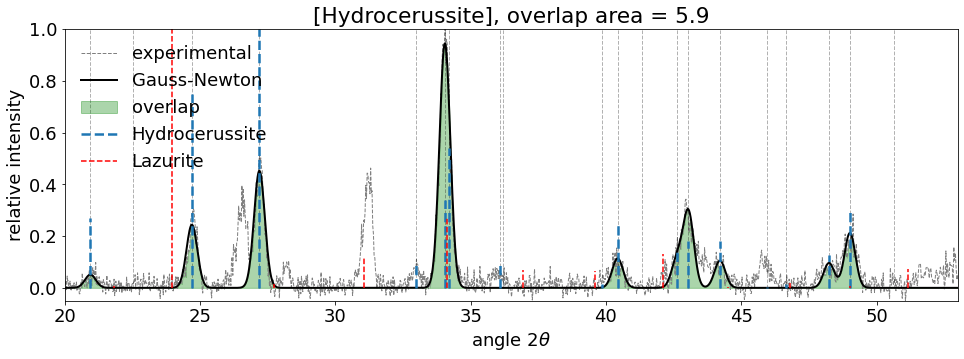

In [23]:
%matplotlib inline
rcParams['font.size'] = 18

x, y = 20, 60

phases_calibration = PhaseList([hydrocerussite])
phase_compare = lazurite
#phase_compare = None

fig, ax = subplots(figsize = (12, 12 * y_x_ratio))
im = ax.imshow(data.signal_background_ratio.squeeze(), interpolation = 'none')
#im = ax.imshow(presence_phases_sel[1], interpolation = 'none')
ax.scatter(x, y, s = 50, c = 'red', marker = 'o')
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
ax.set_title('Signal/background', y = 1.05)

gn = GaussNewton(phases_calibration, FastSpectraXRD().from_Data(data, x, y), min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)

### Leaves initial calibration and only optimizes the heights of the peaks ###
#gn.fit_cycle(gamma = True, steps = 16)

### Optimizes calibration and heights of the peaks ###
gn.fit_cycle(gamma = True, steps = 16).fit_cycle(a = True, s = True, gamma = True, steps = 16).fit_cycle(gamma = True, steps = 16)

fig, ax = subplots(figsize = (16, 5))
sca(ax)
gn.plot_spectrum(c = 'grey', ls = '--', lw = 1, label = 'experimental')
gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
fill_between(gn.theta.squeeze(), gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
gn.phase.plot(color = 'k', lw = 1, lineheight = 1, alpha = 0.3, label = '')
gn.phase.plot(lw = 2.5, alpha = 1)
if phase_compare is not None:
    phase_compare.plot()
ax.set_xlim(min_theta, max_theta)
ax.set_ylim(-0.05, 1)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel(r'relative intensity')
ax.set_title(f'{gn.label}, overlap area = {gn.overlap3_area():.1f}')
legend(frameon = False, loc = 2)
show()